In [227]:
### Import

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score


#Set Plot Size
rcParams['figure.figsize'] = 16,9


### Read Data

df = pd.read_csv("TG_STAID002759.txt")



### Rename Colummns

df.columns = ["Souid", "Date", "TG", "Q_TG"]



### Convert to datetime

df["Date"] = pd.to_datetime(df["Date"], format='%Y%m%d')

df.set_index("Date", inplace=True)

df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day


### Handle Outliers

df.loc['1945-04-25':'1945-11-05', 'TG'] = (df['1946-04-25':'1946-11-05']["TG"].values
                                           + df['1944-04-25':'1944-11-05']["TG"].values) / 2
df["Q_TG"].loc[df['Q_TG'] == 9] = 1


### Transform to Kelvin

df["TG"] /= 10
#df["TG"] +=  273.15



c:\users\bastian matzen\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Train Test Split

In [228]:

y_train = df[:"2019"].copy()
y_test = df["2020"].copy()

In [229]:

### Detrend time series Data

y_train["difference"] = y_train["TG"].diff().fillna(0.0)
y_train["difference"]



Date
1876-01-01    0.0
1876-01-02    0.3
1876-01-03   -2.2
1876-01-04   -6.1
1876-01-05   -4.0
             ... 
2019-12-27   -1.8
2019-12-28   -1.8
2019-12-29   -1.3
2019-12-30    4.5
2019-12-31    1.5
Name: difference, Length: 52595, dtype: float64

In [230]:


### De-seasonalize the series by subtracting daily means

y_train["daily_means"] = y_train.groupby("day")["difference"].transform("mean")
y_train["daily_means"]



Date
1876-01-01   -0.062355
1876-01-02    0.032697
1876-01-03    0.023553
1876-01-04    0.063339
1876-01-05   -0.014959
                ...   
2019-12-27   -0.049566
2019-12-28    0.134433
2019-12-29    0.003552
2019-12-30    0.020076
2019-12-31   -0.039385
Name: daily_means, Length: 52595, dtype: float64

In [231]:

## Baseline model

y0_train = y_train.iloc[0]['TG']

y_train.loc[0,'daily_means'] = y0_train
y_train.loc[0,'daily_means']

2.2

In [232]:

y_train['Prediction'] = np.cumsum(y_train['daily_means'])
y_train['Prediction']

Date
1876-01-01   -0.062355
1876-01-02   -0.029659
1876-01-03   -0.006105
1876-01-04    0.057234
1876-01-05    0.042274
                ...   
2019-12-27    5.943680
2019-12-28    6.078113
2019-12-29    6.081664
2019-12-30    6.101740
2019-12-31    6.062355
Name: Prediction, Length: 52595, dtype: float64

In [233]:
#Do the same to testing
y_test['daily_means'] = y_train.iloc[0:182]["daily_means"].values

In [234]:
y_test.iloc[0]['TG']

2.7

In [235]:

y_test['daily_means'][0] = y_test.iloc[0]['TG']
y_test['daily_means']

<ipython-input-235-2ee709da4741>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['daily_means'][0] = y_test.iloc[0]['TG']


Date
2020-01-01    2.700000
2020-01-02    0.032697
2020-01-03    0.023553
2020-01-04    0.063339
2020-01-05   -0.014959
                ...   
2020-06-26    0.062413
2020-06-27   -0.049566
2020-06-28    0.134433
2020-06-29    0.003552
2020-06-30    0.020076
Name: daily_means, Length: 182, dtype: float64

In [236]:

#replaces the first point with the real value, so the cumulative sum can be built off of this.

y_test['Prediction'] = np.cumsum(y_test['daily_means'])
y_test['Prediction']

Date
2020-01-01    2.700000
2020-01-02    2.732697
2020-01-03    2.756250
2020-01-04    2.819589
2020-01-05    2.804630
                ...   
2020-06-26    2.678054
2020-06-27    2.628488
2020-06-28    2.762921
2020-06-29    2.766473
2020-06-30    2.786549
Name: Prediction, Length: 182, dtype: float64

Test Score: -1.6260311784025228


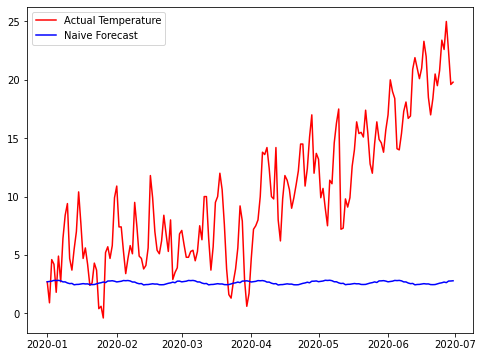

In [237]:
plt.figure(figsize=(8, 6))
plt.plot_date(y_test.index,y_test['TG'],'r-')
plt.plot_date(y_test.index,y_test['Prediction'],'b-')
plt.legend(['Actual Temperature', 'Naive Forecast'])

print(f"Test Score: {r2_score(y_test['TG'], y_test['Prediction'])}")